In [17]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import networkx as nx
from scipy.special import expit, logit
from scipy.optimize import fsolve
import statsmodels.api as sm

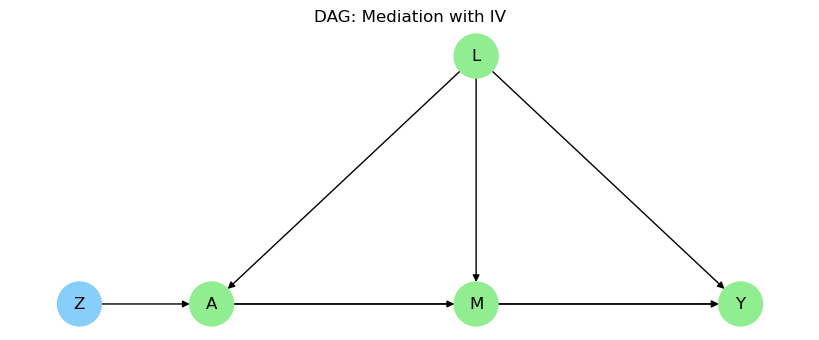

In [43]:
import networkx as nx
import matplotlib.pyplot as plt

def draw_dag():
    G = nx.DiGraph()
    edges = [("L", "A"), ("L", "M"), ("L", "Y"),
             ("A", "M"), ("A", "Y"), ("M", "Y"),
             ("Z", "A")]
    G.add_edges_from(edges)

    pos = {"L": (4, 2), "A": (2, 1), "M": (4, 1), "Y": (6, 1), "Z": (1, 1)}

    nodelist = ["Z", "L", "A", "M", "Y"]
    node_colors = ["lightskyblue" if n == "Z" else "lightgreen" for n in nodelist]

    plt.figure(figsize=(8, 3))
    nx.draw(
        G, pos,
        nodelist=nodelist,
        with_labels=True,
        node_color=node_colors,
        node_size=1000,
        arrowsize=10
    )
    plt.title("DAG: Mediation with IV")
    plt.show()

draw_dag()

## MLE with and without IV

In [33]:
def run_mle_simulations():
    np.random.seed(42)
    N = 10**6

    psi_a_direct_true = 0.6  
    psi_m_on_y_true = 1.0    
    psi_a_on_m_true = 0.8    

    Z = np.random.binomial(1, 0.5, N)
    L = np.random.normal(0, 1, N)

    A = np.random.binomial(1, expit(-1 + 1.2 * Z + 0.5 * L))

    M = np.random.binomial(1, expit(-1.5 + psi_a_on_m_true * A + 0.5 * L))

    Y = np.random.binomial(1, expit(-2 + psi_a_direct_true * A + psi_m_on_y_true * M + 0.7 * L))

    data = pd.DataFrame({'Z': Z, 'L': L, 'A': A, 'M': M, 'Y': Y})


    X1 = sm.add_constant(data[['A', 'M', 'L']])
    model1 = sm.Logit(data['Y'], X1).fit(disp=0)
    params1 = model1.params


    X2 = sm.add_constant(data[['A', 'M', 'L', 'Z']])
    model2 = sm.Logit(data['Y'], X2).fit(disp=0)
    params2 = model2.params

    results = pd.DataFrame({
        "Parameter": ["Intercept", "A (Direct Effect)", "M (Mediator)", "L (Confounder)", "Z (Instrument)"],
        "True Value": [-2.0, psi_a_direct_true, psi_m_on_y_true, 0.7, 0.0],
        "MLE (Without Z)": list(params1) + [None],
        "MLE (With Z)": list(params2)
    })

    print(results.to_string(index=False))

run_mle_simulations()

        Parameter  True Value  MLE (Without Z)  MLE (With Z)
        Intercept        -2.0        -1.997128     -1.997273
A (Direct Effect)         0.6         0.590593      0.590484
     M (Mediator)         1.0         1.004349      1.004349
   L (Confounder)         0.7         0.701511      0.701524
   Z (Instrument)         0.0              NaN      0.000379


## G Estimation with and without IV

In [34]:
def run_gest_comparison():
    np.random.seed(42)
    N = 10**6
    
    psi_a_direct_true = 0.6
    psi_m_on_y_true = 1.0
    psi_a_on_m_true = 0.8
    
    Z = np.random.binomial(1, 0.5, N)
    L = np.random.normal(0, 1, N)
    A = np.random.binomial(1, expit(-1 + 1.2 * Z + 0.5 * L))
    M = np.random.binomial(1, expit(-1.5 + psi_a_on_m_true * A + 0.5 * L))
    Y = np.random.binomial(1, expit(-2 + psi_a_direct_true * A + psi_m_on_y_true * M + 0.7 * L))

    data = pd.DataFrame({'Z': Z, 'L': L, 'A': A, 'M': M, 'Y': Y})

    model_y = sm.Logit(data['Y'], sm.add_constant(data[['A', 'M', 'L']])).fit(disp=0)
    psi_m_hat = model_y.params['M']
    y_logit_pred = model_y.predict(sm.add_constant(data[['A', 'M', 'L']]), linear=True)

    p_a_l = sm.Logit(data['A'], sm.add_constant(data['L'])).fit(disp=0).predict(sm.add_constant(data['L']))

    def g_eqn_no_iv(psi_guess):
        h = expit(y_logit_pred - (psi_guess * A) - (psi_m_hat * M))
        return np.mean((data['A'] - p_a_l) * h)

    gest_no_iv = fsolve(g_eqn_no_iv, x0=0.0)[0]

    p_z_l = sm.Logit(data['Z'], sm.add_constant(data['L'])).fit(disp=0).predict(sm.add_constant(data['L']))

    def g_eqn_with_iv(psi_guess):
        h = expit(y_logit_pred - (psi_guess * A) - (psi_m_hat * M))
        return np.mean((data['Z'] - p_z_l) * h)

    gest_with_iv = fsolve(g_eqn_with_iv, x0=0.0)[0]

    results = pd.DataFrame({
        "Method": ["True Value", "G-estimation (No IV)", "G-estimation (With IV)"],
        "Estimate": [psi_a_direct_true, gest_no_iv, gest_with_iv]
    })
    
    print(results.to_string(index=False))

if __name__ == "__main__":
    run_gest_comparison()

                Method  Estimate
            True Value  0.600000
  G-estimation (No IV)  0.590314
G-estimation (With IV)  0.588392
